In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision import models
from sklearn.metrics import recall_score
from sklearn.preprocessing import normalize

import sys
import argparse
import json
from PIL import Image
import yaml
from tqdm import tqdm
import albumentations as A
import albumentations.pytorch
import warnings
import time
import glob

warnings.filterwarnings("ignore")

In [ ]:
#Read the image
def read_image(image_dir):
    out_paths = []
    for i in tqdm(image_dir):
        image_name = os.path.basename(i)
        out_paths.append((np.array(Image.open(i), dtype='uint8'), image_name))
    return out_paths

In [ ]:
def process_image(image, transform):
    out_image = image[0]

    image_name = image[1]

    if transform is not None:
        augmented = transform(image=out_image)
        out_image = augmented['image']

    out_image = torch.from_numpy(out_image).permute(2,0,1)
    return out_image, image_name

In [ ]:
def PR(pr):
      for i in range(len(pr)):
        curr_class = pr[i]
        tp = curr_class[0]
        fn = curr_class[1]
        fp = curr_class[2]
        print(f"class: {i} -- precision: {tp / (tp + fp)} -- recall: {tp / (tp + fn)}")

In [ ]:
def generate(model_path, images_arr, labels, batch_size , image_size, predict_dict, class_weights):

    transform = A.Compose(
        transforms=[
            A.RandomCrop(750, 750),
            A.Resize(image_size, image_size),
            A.Normalize(mean=((0.4680, 0.4038, 0.2885)), std=(0.2476, 0.2107, 0.1931))
        ],
        p=1.0,
    )

    model = torch.load(model_path)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    image_batch = []
    name_batch = []
    label_batch = []

    counter = 0
    batch_counter = 0

    temp_img = []
    temp_name = []
    temp_label = []

    for i in tqdm(range(len(images_arr))):
        image, image_name = process_image(images_arr[i], transform)

        label = labels[image_name]

        if label == 'unfertilized':
            out_label = 0
        elif label == '_PKCa':
            out_label = 1
        elif label == 'N_KCa':
            out_label = 2
        elif label == 'NP_Ca':
            out_label = 3
        elif label == 'NPK_':
            out_label = 4
        elif label == 'NPKCa':
            out_label = 5
        else:
            out_label = 6

        out_label = torch.tensor(out_label)
        temp_img.append(image)
        temp_name.append(image_name)
        temp_label.append(out_label)

        batch_counter += 1

        if batch_counter == batch_size:
            temp_img = torch.stack(temp_img, dim=0)
            temp_label = torch.stack(temp_label, dim=0)

            image_batch.append(temp_img)
            name_batch.append(temp_name)
            label_batch.append(temp_label)

            temp_img = []
            temp_name = []
            temp_label = []

            batch_counter = 0

    if len(temp_img) > 0:
        temp_img = torch.stack(temp_img, dim=0)
        temp_label = torch.stack(temp_label, dim=0)

        image_batch.append(temp_img)
        name_batch.append(temp_name)
        label_batch.append(temp_label)

    for i in tqdm(range(len(image_batch))):
        image = image_batch[i].to(device)
        label = label_batch[i].to(device)

        with torch.no_grad():
            output = model(image)
            output = output.cpu()
            label = label.cpu()

            for j in range(len(output)):
                name = name_batch[i][j]
                prediction = int(torch.argmax(output[j]).numpy())
                truth = label[j].item()

                if name in predict_dict:
                    predict_dict[name][0][prediction] += class_weights[prediction]
                    predict_dict[name][1] = truth
                else:
                    predict_dict[name] = [[0 for i in range(7)], -1]
                    predict_dict[name][0][prediction] += class_weights[prediction]
                    predict_dict[name][1] = truth

    return predict_dict, image_batch, label_batch


In [ ]:
def model_evaluate(model_path, image_batch, label_batch, device, name=""):
    model = torch.load(model_path)
    model.to(device)
    model.eval()
    this_matrix = [[0 for i in range(7)] for j in range(7)]
    this_pr = [[0 for i in range(3)] for j in range(7)]

    for i in tqdm(range(len(image_batch))):
        image = image_batch[i].to(device)
        label = label_batch[i].to(device)

        with torch.no_grad():
            outputs = model(image)
            outputs = outputs.cpu()
            label = label.cpu()

            for i in range(len(outputs)):
              prediction = torch.argmax(outputs[i]).item()
              actual = label[i].item()


              this_matrix[prediction][actual] += 1

              if actual == prediction:
                this_pr[actual][0] += 1

              else:
                this_pr[prediction][1] += 1
                this_pr[actual][2] += 1
    print(f'\n\n---------{name}---------\n\n')

    PR(this_pr)
    tmp = np.array(normalize(this_matrix, axis=1, norm='l1'))
    print()
    sns.heatmap(tmp, annot=True)

In [ ]:
def ensemble_evaluate(prediction_dict):
    this_matrix = [[0 for i in range(7)] for j in range(7)]
    this_pr = [[0 for i in range(3)] for j in range(7)]

    total_correct = 0
    total = len(prediction_dict)

    for name in tqdm(prediction_dict):
      curr_item = prediction_dict[name]
      prediction = np.argmax(curr_item[0])
      label = curr_item[1]

      this_matrix[prediction][label] += 1

      if label == prediction:
        this_pr[label][0] += 1
        total_correct += 1
      else:
        this_pr[prediction][1] += 1
        this_pr[label][2] += 1

    print(f'\n\n--------- ENSEMBLE LEARNER ---------\n\n')

    PR(this_pr)
    tmp = np.array(normalize(this_matrix, axis=1, norm='l1'))
    print()
    sns.heatmap(tmp, annot=True)
    accuracy = total_correct/total
    print(f'Accuracy: {accuracy:6.4f}')


In [ ]:
if __name__ == '__main__':
    efficient_net = r'/content/drive/MyDrive/iccv23/models/efficient_net_b6_160_no_tiles_BEST.pth'
    google_net = r'/content/drive/MyDrive/iccv23/models/google_160_no_tiles_combined.pth'
    resnet = r'/content/drive/MyDrive/iccv23/models/res_net_152_160_no_tiles_BEST.pth'
    resnext = r'/content/drive/MyDrive/iccv23/models/resnext101_32x8d_160_no_tiles_BEST.pth'
    shuffle_net = r'/content/drive/MyDrive/iccv23/models/shufflenet_v2_x1_0_no_tiles_BEST.pth'
    val_set = r'/content/drive/MyDrive/iccv23/val_image'
    yml = r'/content/drive/MyDrive/iccv23/updated_yml.yml'
    batch_size = 32
    num_process = 2
    image_size = 224
    run_amount = 5

    with open(yml, 'r') as f:
      labels = yaml.safe_load(f)

    image_dir = np.array(glob.glob(f'{val_set}/*.jpg'))
    images = read_image(image_dir)

    # Running Efficient Net

    transformed_images = []
    labels_ = []
    pred_dict = {}

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for i in range(run_amount):

      print(f'\n\n --- iteration : {i} ---\n\n')

      pred_dict, img_temp, label_tmp = generate(efficient_net, images, labels, batch_size, 528, pred_dict, [0.92,0.89,0.6,0.41,0.9,0.84,0.97])
      transformed_images += img_temp
      labels_ += label_tmp




100%|██████████| 402/402 [00:20<00:00, 19.29it/s]




 --- iteration : 0 ---




100%|██████████| 13/13 [00:16<00:00,  1.23s/it]




 --- iteration : 1 ---




100%|██████████| 13/13 [00:14<00:00,  1.15s/it]




 --- iteration : 2 ---




100%|██████████| 13/13 [00:15<00:00,  1.17s/it]




 --- iteration : 3 ---




100%|██████████| 13/13 [00:14<00:00,  1.15s/it]




 --- iteration : 4 ---




100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


100%|██████████| 65/65 [01:14<00:00,  1.15s/it]




---------EFFICIENT NET---------


class: 0 -- precision: 1.0 -- recall: 0.8950617283950617
class: 1 -- precision: 0.6333333333333333 -- recall: 0.8769230769230769
class: 2 -- precision: 0.32068965517241377 -- recall: 0.5470588235294118
class: 3 -- precision: 0.9689655172413794 -- recall: 0.3957746478873239
class: 4 -- precision: 0.6172413793103448 -- recall: 0.9086294416243654
class: 5 -- precision: 0.4379310344827586 -- recall: 0.8355263157894737
class: 6 -- precision: 0.8793103448275862 -- recall: 0.9732824427480916



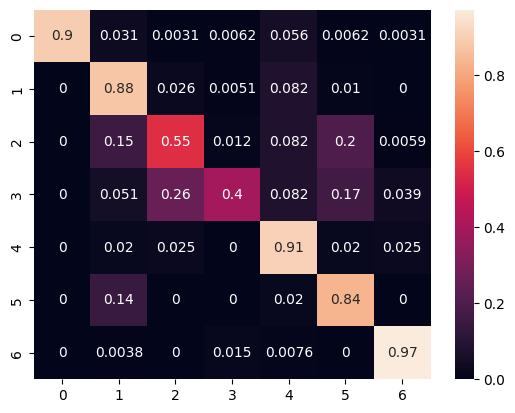

In [ ]:
    model_evaluate(efficient_net, transformed_images, labels_, device, "EFFICIENT NET")

    transformed_images = []
    labels_ = []

    time.sleep(3)

In [ ]:
    for i in range(run_amount):
      print(f'\n\n --- iteration : {i} ---\n\n')

      pred_dict, img_temp, label_tmp = generate(google_net, images, labels, batch_size, image_size, pred_dict, [0.77, 0.79, 0.51, 0.4, 0.83, 0.56, 0.95])
      pred_dict, img_temp, label_tmp = generate(resnet, images, labels, batch_size, image_size, pred_dict, [0.81, 0.81, 0.6, 0.44, 0.82, 0.56, 0.95])
      pred_dict, img_temp, label_tmp = generate(resnext, images, labels, batch_size, image_size, pred_dict, [0.85, 0.82, 0.65, 0.36, 0.97, 0.59, 0.99])
      pred_dict, img_temp, label_tmp = generate(shuffle_net, images, labels, batch_size, image_size, pred_dict, [0.93, 0.82, 0.65, 0.36, 0.97, 0.59, 0.99])


      transformed_images += img_temp
      labels_ += label_tmp




 --- iteration : 0 ---




100%|██████████| 13/13 [00:00<00:00, 52.24it/s]




 --- iteration : 1 ---




100%|██████████| 13/13 [00:00<00:00, 65.50it/s]




 --- iteration : 2 ---




100%|██████████| 13/13 [00:00<00:00, 65.81it/s]




 --- iteration : 3 ---




100%|██████████| 13/13 [00:00<00:00, 54.00it/s]




 --- iteration : 4 ---




100%|██████████| 13/13 [00:00<00:00, 60.09it/s]


100%|██████████| 65/65 [00:02<00:00, 26.65it/s]




---------GOOGLE NET---------


class: 0 -- precision: 0.896551724137931 -- recall: 0.7926829268292683
class: 1 -- precision: 0.5481481481481482 -- recall: 0.8222222222222222
class: 2 -- precision: 0.38275862068965516 -- recall: 0.4977578475336323
class: 3 -- precision: 0.8241379310344827 -- recall: 0.3911620294599018
class: 4 -- precision: 0.3793103448275862 -- recall: 0.8870967741935484
class: 5 -- precision: 0.4689655172413793 -- recall: 0.5619834710743802
class: 6 -- precision: 0.9793103448275862 -- recall: 0.9403973509933775



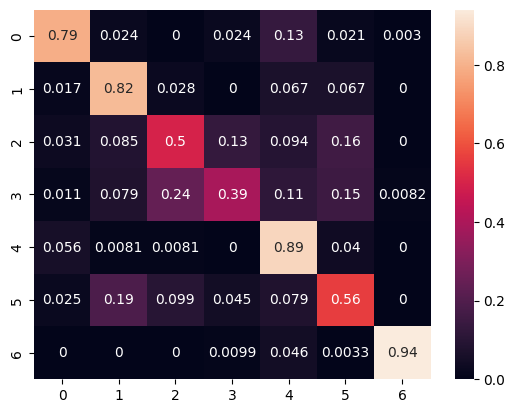

In [ ]:
    model_evaluate(google_net, transformed_images, labels_, device, "GOOGLE NET")

100%|██████████| 65/65 [00:14<00:00,  4.57it/s]




---------RESNET---------


class: 0 -- precision: 0.9172413793103448 -- recall: 0.8209876543209876
class: 1 -- precision: 0.48148148148148145 -- recall: 0.8024691358024691
class: 2 -- precision: 0.4482758620689655 -- recall: 0.593607305936073
class: 3 -- precision: 0.7379310344827587 -- recall: 0.4403292181069959
class: 4 -- precision: 0.5517241379310345 -- recall: 0.8080808080808081
class: 5 -- precision: 0.5793103448275863 -- recall: 0.535031847133758
class: 6 -- precision: 0.9827586206896551 -- recall: 0.9283387622149837



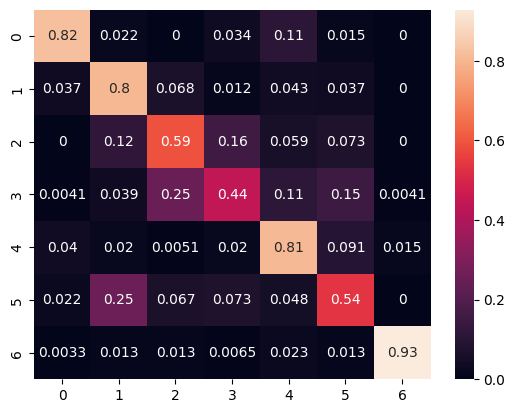

In [ ]:
    model_evaluate(resnet, transformed_images, labels_, device, "RESNET")

100%|██████████| 65/65 [00:23<00:00,  2.72it/s]




---------ResNeXt---------


class: 0 -- precision: 0.9137931034482759 -- recall: 0.8520900321543409
class: 1 -- precision: 0.5148148148148148 -- recall: 0.8424242424242424
class: 2 -- precision: 0.3896551724137931 -- recall: 0.6243093922651933
class: 3 -- precision: 0.9310344827586207 -- recall: 0.3683492496589359
class: 4 -- precision: 0.43103448275862066 -- recall: 0.9541984732824428
class: 5 -- precision: 0.46551724137931033 -- recall: 0.5973451327433629
class: 6 -- precision: 0.8896551724137931 -- recall: 0.9809885931558935



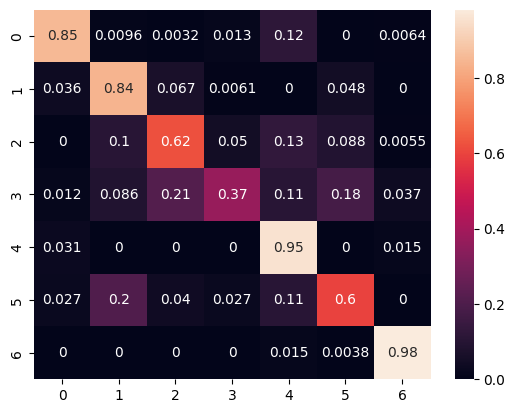

In [ ]:
    model_evaluate(resnext, transformed_images, labels_, device, "ResNeXt")

100%|██████████| 65/65 [00:01<00:00, 64.81it/s]




---------SHUFFLE NET---------


class: 0 -- precision: 0.906896551724138 -- recall: 0.9163763066202091
class: 1 -- precision: 0.5296296296296297 -- recall: 0.9050632911392406
class: 2 -- precision: 0.5137931034482759 -- recall: 0.5155709342560554
class: 3 -- precision: 0.8448275862068966 -- recall: 0.4131534569983137
class: 4 -- precision: 0.4862068965517241 -- recall: 0.94
class: 5 -- precision: 0.4827586206896552 -- recall: 0.5405405405405406
class: 6 -- precision: 0.9310344827586207 -- recall: 0.9854014598540146



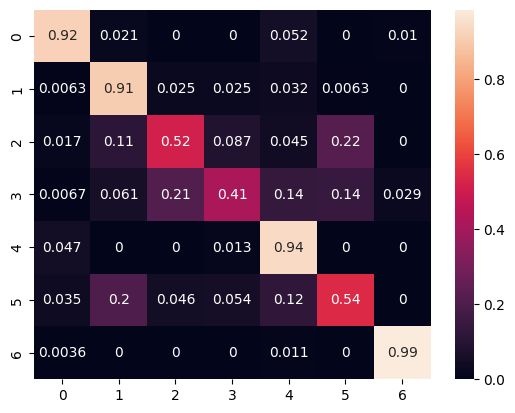

In [ ]:
    model_evaluate(shuffle_net, transformed_images, labels_, device, "SHUFFLE NET")

100%|██████████| 402/402 [00:00<00:00, 78584.55it/s]




--------- ENSEMBLE LEARNER ---------


class: 0 -- precision: 0.9827586206896551 -- recall: 0.8507462686567164
class: 1 -- precision: 0.6111111111111112 -- recall: 0.9166666666666666
class: 2 -- precision: 0.5 -- recall: 0.6904761904761905
class: 3 -- precision: 0.8620689655172413 -- recall: 0.4424778761061947
class: 4 -- precision: 0.6379310344827587 -- recall: 0.9736842105263158
class: 5 -- precision: 0.5862068965517241 -- recall: 0.7391304347826086
class: 6 -- precision: 1.0 -- recall: 0.9666666666666667

Accuracy: 0.7413


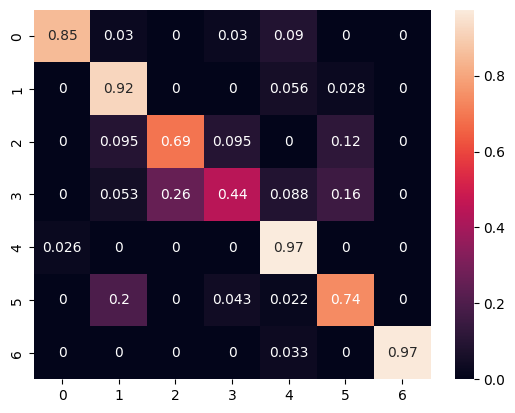

In [ ]:
    ensemble_evaluate(pred_dict)